### Import dependencies

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### import data

In [21]:
df = pd.read_csv("medical_examination.csv")

df.sample(n=5, random_state=26)

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
45357,64800,20420,2,171,72.0,140,80,1,1,0,0,1,1
23398,33427,23346,2,165,78.0,130,80,2,1,1,1,1,1
39769,56828,21214,1,155,70.0,120,80,1,1,0,0,0,1
47166,67365,16068,1,160,75.0,80,120,2,1,0,0,1,0
2961,4175,14378,1,167,67.0,110,80,1,1,0,0,1,0


### Add an overweight column to the data.
To determine if a person is overweight, first calculate their BMI by dividing their weight in kilograms by the square of their height in meters. If that value is > 25 then the person is overweight. Use the value 0 for NOT overweight and the value 1 for overweight.

In [22]:
bmi = df["weight"] / (df["height"] / 100) ** 2
df["overweight"] = (bmi > 25).astype(int)

### Normalize the data by making 0 always good and 1 always bad. 
If the value of cholesterol or gluc is 1, make the value 0. If the value is more than 1, make the value 1.

In [23]:
df[["cholesterol", "gluc"]] = (df[["cholesterol", "gluc"]] > 1).astype(int)

In [24]:
df.sample(n=5, random_state=26)

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,overweight
45357,64800,20420,2,171,72.0,140,80,0,0,0,0,1,1,0
23398,33427,23346,2,165,78.0,130,80,1,0,1,1,1,1,1
39769,56828,21214,1,155,70.0,120,80,0,0,0,0,0,1,1
47166,67365,16068,1,160,75.0,80,120,1,0,0,0,1,0,1
2961,4175,14378,1,167,67.0,110,80,0,0,0,0,1,0,0


### Convert data into long format and create a chart that shows the value counts of the categorical features using seaborn's `catplot()`.

The dataset should be split by 'Cardio' so there is one chart for each `cardio` value. The chart should look like

In [27]:
df_cat = pd.melt(df, id_vars=["cardio"], value_vars=["active", "alco", "cholesterol", "gluc", "overweight", "smoke"])
df_cat["total"] = 1
df_cat = df_cat.groupby(["cardio", "variable", "value"], as_index=False).count()
df_cat.sample(10)

,cardio,variable,value,total
3,0,alco,1,1941
20,1,overweight,0,10539
4,0,cholesterol,0,29330
18,1,gluc,0,28585
22,1,smoke,0,32050
6,0,gluc,0,30894
11,0,smoke,1,3240
12,1,active,0,7361
9,0,overweight,1,19106
16,1,cholesterol,0,23055


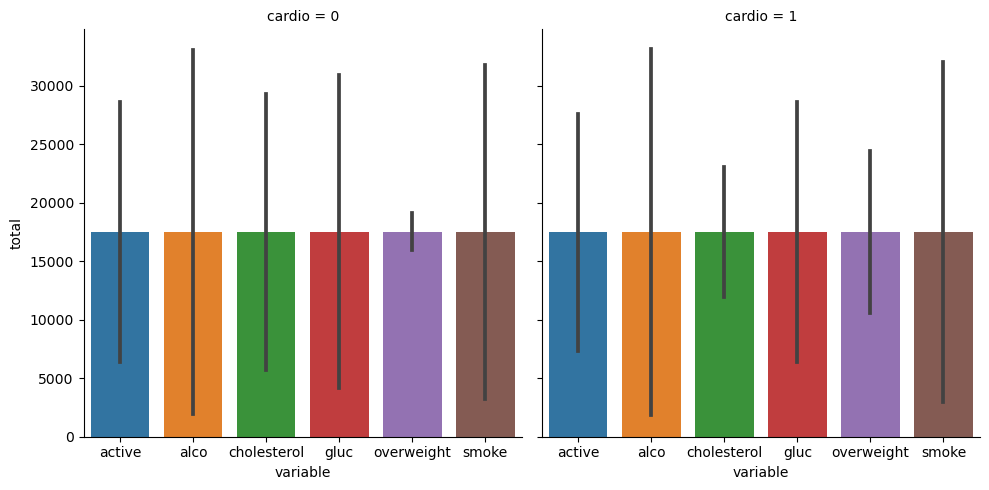

In [29]:
fig = sns.catplot(
    data=df_cat,
    x="variable",
    y="total",
    col="cardio",
    kind="bar",
    hue="value"
)